# N qubits time-independent Hamiltonian Simulation
This notebook will enable classical simulation of n qubits in state $|00...0\rangle$ with a time-independent Hamiltonian of the form: $H = \sigma_x \otimes \sigma_x \otimes \sigma_x...\otimes \sigma_x$.

Three methods of simulation will be used: Qutip sesolve(), exact simulation and Qiskit gate module.

First, import all the libraries:

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

# for 3d interactive display of the bloch sphere
from kaleidoscope import bloch_sphere
from matplotlib.colors import LinearSegmentedColormap, rgb2hex
from qiskit.quantum_info import Statevector, partial_trace

# for analytical exponentiation
from scipy.linalg import expm 

# qiskit
from qiskit import QuantumCircuit, Aer, assemble, transpile
from qiskit.providers.aer import AerSimulator

# Time performance
import time

print("success")


success


Initialize the simulation variables:

In [4]:
# number of qubits
n = 2

# define time steps
times = np.linspace(0.0, 10, 100)


## Qutip Simulation
Define the Qutip simulation method. This method outputs state evolution results in the Z-basis. It takes as inputs: n-number of qubits, times- a list of time steps, and options-a list of parameters to adjust the approximation error in sesolve().

In [21]:
# This method simulate the time evolution of n-qubits with time independent Hamiltonian using sesolve() of Qutip
# Outputs: state evolution results in the Z-basis, time taken to execure
# Inputs: n: number of qubits, times: a list of time steps, and options:a list of parameters to adjust the 
# approximation error in sesolve()
def qutib_simulate(n, times, options):
    
    # Time performance
    begin_time = time.time() 
    
    # initial state
    initial_state = qutip_construct_initial_state(n)
    
    # generate Hamiltonian
    h = qutip_construct_hamiltonian(n)
    
    # simulate
    if not options:
        result = sesolve(h, initial_state, times)
    else:
        
        result = sesolve(h, initial_state, times, options = options)
    return result.states, time.time()  - begin_time

# generates sigma_x tensored with itself n times where n is the number of qubits in the system 
def qutip_construct_hamiltonian(n):
    h = []
    for _ in range(n):
        h.append(sigmax())
    h = tensor(h)
    return h

def qutip_construct_initial_state(n):
    initial_state = []
    for _ in range(n):
        initial_state.append(basis(2, 0))
    initial_state = tensor(initial_state)
    return initial_state
    
# options = Options(atol=1e-10)
# # # print(options)
# qutip_sim = qutib_simulate(n, times, options)
# print(qutip_sim)

## Exact Simulation


In [20]:
# This method simulate the time evolution of n-qubits with time independent Hamiltonian by building the Unitary operator
# Outputs: state evolution results in the Z-basis, time taken to execute
# Inputs: n: number of qubits, time_step: the time step of the unitary (the angle of rotation each time unit),
# and num_steps: the number of times to apply the unitary
def exact_simulate(n, time_step, num_steps):
    
    # Time performance
    begin_time = time.time() 
    
    # initial state
    initial_state = exact_construct_initial_state(n)
    
    # generate Hamiltonian
    h = exact_construct_hamiltonian(n)
    
    # construct U
    u = exact_construct_U(h, n, time_step)
    
    # simulate
    states = [convert_from_x_basis_to_z_basis(initial_state)]
    state = initial_state
    for t in range(num_steps - 1):
        state = np.matmul(u, state)
        states.append(convert_from_x_basis_to_z_basis(state))  
    return states, time.time()  - begin_time


# construct the state |0> tensored with itself n times in the x-basis
# we are working with x-basis so that h can be a diagonal matrix (a matrix that is sigma_x tensored with itself n times
# is diagonal in the x basis) 
def exact_construct_initial_state(n):
    zero_in_x = 1/np.sqrt(2) * np.array([[1], [1]])
    initial_state = zero_in_x
    for _ in range(n-1):
        initial_state = np.kron(initial_state, zero_in_x)
    return initial_state


# generates sigma_x tensored with itself n times in the x basis so that h is a diagonal matrix-n is the number of 
# qubits in the system 
def exact_construct_hamiltonian(n):
    sigma_x_in_x = np.array([[1, 0], [0, -1]])
    h = sigma_x_in_x
    for _ in range(n-1):
        h = np.kron(h, sigma_x_in_x)
    return h

def exact_construct_U(h, n, t):
    u = h.astype(complex)
    for i in range(np.power(n, 2)):
        u[i][i] = np.exp(-1j*t*u[i][i])
    return u

def convert_from_x_basis_to_z_basis(x_state):
    z_state = np.array([0.5 * (x_state[0] + x_state[1] + x_state[2] + x_state[3]), 0.5 * (x_state[0] + x_state[1] - x_state[2] - x_state[3]),
                       0.5 * (x_state[0] - x_state[1] + x_state[2] - x_state[3]), 0.5 * (x_state[0] - x_state[1] - x_state[2] + x_state[3])])
    return z_state


# exact_sim, delta = exact_simulate(n, 0.1, 100)
# print(delta)

0.0076580047607421875


In [5]:

def change_of_basis_matrix_x_to_z(n):
    z_pluse = np.matrix([[1], [0]])
    z_minus = np.matrix([[0], [1]])
    x_pluse = 1/np.sqrt(2)*(z_pluse + z_minus)
    x_minus = 1/np.sqrt(2)*(z_pluse - z_minus)
    
    # first find all the x kets
    x_kets = []
    for i in range(np.power(2, n)):
        
    
    s = np.array([[(z_pluse.getH() * x_pluse).item(0), (z_pluse.getH() * x_minus).item(0)],
                  [(z_minus.getH() * x_pluse).item(0), (z_minus.getH() * x_minus).item(0)]])
    
    print(z_minus)
    print(x_minus)
    return np.matmul(s, x_pluse)
change_of_basis_matrix_x_to_z(n)

IndentationError: expected an indented block (<ipython-input-5-e917f88bd1c5>, line 12)

# Qiskit Simulation

In [25]:
# This method simulate the time evolution of n-qubits with time independent Hamiltonian usig
# Outputs: state evolution results in the Z-basis, time taken to execute
# Inputs: n: number of qubits, time_step: the time step of the unitary (the angle of rotation each time unit),
# and num_steps: the number of times to apply the unitary
def qiskit_simulate(n, time_step, num_steps):
    
    # Time performance
    begin_time = time.time()
    
    # create the quntum simulator
    svsim = Aer.get_backend('statevector_simulator')
    
    # create a quantum circuit of n qubits (sets the initial state of the qubits to |0>)
    qc = QuantumCircuit(n)
    
    # angle of rotation
    angle = 2*time_step
    
    # append initial state to the states evolution array
    states = []
    states.append(Statevector.from_instruction(qc).data)
    for _ in range(num_steps - 1):
        for j in range(n - 1):
            qc.cx(0, n - j - 1)
        qc.rx(angle, 0)
        for j in range(1, n):
            qc.cx(0, j)
        states.append(Statevector.from_instruction(qc).data)
    return states, time.time() - begin_time

def appx_qiskit_simulate(n, time_step, num_steps):
    
    # Create extended stabilizer method simulator
    extended_stabilizer_simulator = AerSimulator(method='extended_stabilizer')
    
    # create a quantum circuit of n qubits (sets the initial state of the qubits to |0>)
    qc = QuantumCircuit(n)
    qc.save_statevector('psi')
    
    
    
    # angle of rotation
    angle = 2*time_step
    
    # append initial state to the states evolution array
    for i in range(num_steps - 1):
        for j in range(n - 1):
            qc.cx(0, n - j - 1)
        qc.rx(angle, 0)
        for j in range(1, n):
            qc.cx(0, j)
        qc.save_statevector(label=f'psi_{i}')
    
    # Transpile circuit for backend
    tcirc = transpile(qc, extended_stabilizer_simulator)
    result = extended_stabilizer_simulator.run(tcirc).result()
    return result.data(0)
    
#     return extended_stabilizer_simulator.run(tcirc).result()
    
# exact_sim = qiskit_simulate(n, 0.1, 100)
# appx_qiskit_simulate(n, 0.1, 100)


# Analysis
Here I will investigate how changing the options for sesolve() will change the accurecy of the result. 

In the source code for sesolve(), the main method performing most of the calculation is scipy.integrate.ode() (https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html). This method can take options to change the integrator and the error tolerance. The integrator is set by default by qutip sesolve() to "zvode" (r.set_integrator('zvode', options) in sesolve() source code), but we can still set error tolerance and method of integration using the options argument. The VODE paper is: "P. N. Brown, G. D. Byrne, and A. C. Hindmarsh, 1989. VODE: A Variable Coefficient ODE Solver, SIAM J. Sci. Stat. Comput., 10, pp. 1038-1051. Also, LLNL Report UCRL-98412, June 1988." Documentation for the zvode integrator is found here: http://www.netlib.org/ode/zvode.f. Documentation on the options supplied can be found here: https://qutip.org/docs/latest/guide/dynamics/dynamics-options.html.

The options describtion are as follows (this is from sesolve() documentation, a more detailed descibtion can be found in the zvode documentaion):
atol : float or sequence absolute tolerance for solution

rtol : float or sequence relative tolerance for solution

lband : None or int

uband : None or int Jacobian band width, jac[i,j] != 0 for i-lband <= j <= i+uband. Setting these requires your jac routine to return the jacobian in packed format, jac_packed[i-j+uband, j] = jac[i,j]. The dimension of the matrix must be (lband+uband+1, len(y)).

method: ‘adams’ or ‘bdf’ Which solver to use, Adams (non-stiff) or BDF (stiff)

with_jacobian : bool This option is only considered when the user has not supplied a Jacobian function and has not indicated (by setting either band) that the Jacobian is banded. In this case, with_jacobian specifies whether the iteration method of the ODE solver’s correction step is chord iteration with an internally generated full Jacobian or functional iteration with no Jacobian.

nsteps : int Maximum number of (internally defined) steps allowed during one call to the solver.

first_step : float

min_step : float

max_step : float Limits for the step sizes used by the integrator.

order : int Maximum order used by the integrator, order <= 12 for Adams, <= 5 for BDF.


In [15]:
# The default for options are:
print("the defaults fro options are:")
print(Options())

the defaults fro options are:
Options:
-----------
atol:              1e-08
rtol:              1e-06
method:            adams
order:             12
nsteps:            1000
first_step:        0
min_step:          0
max_step:          0
tidy:              True
num_cpus:          4
norm_tol:          0.001
norm_steps:        5
rhs_filename:      None
rhs_reuse:         False
seeds:             0
rhs_with_state:    False
average_expect:    True
average_states:    False
ntraj:             500
store_states:      False
store_final_state: False



In [77]:
# number of qubits
n = 2

# define time steps
times = np.linspace(0.0, 10, 100)

time_perf = []

# exact------------------------------------------------
exact_sim, t = exact_simulate(n, 0.1, 100)
time_perf.append(t)

# qiskit-----------------------------------------------
qiskit_sim, t = qiskit_simulate(n, 0.1, 100)
time_perf.append(t)

# qiskit_1 = appx_qiskit_simulate(n, 0.1, 100)


# qutip------------------------------------------------
# default
qutib_sim_1, t = qutib_simulate(n, times, Options())
time_perf.append(t)

# increase the absolute tolerance (previously 1e-8)
options = Options(atol=1e-6)
qutib_sim_2, t = qutib_simulate(n, times, options)
time_perf.append(t)

# increase the relative tolerance (previously 1e-6)
options = Options(rtol = 1e-4)
qutib_sim_3, t = qutib_simulate(n, times, options)
time_perf.append(t)

# increase both the relative and absolute tolerance
options = Options(atol=1e-6, rtol = 1e-4)
qutib_sim_4, t = qutib_simulate(n, times, options)
time_perf.append(t)

# decrease the absolute and relative tolerance
options = Options(atol=1e-10, rtol = 1e-8)
qutib_sim_5, t = qutib_simulate(n, times, options)
time_perf.append(t)

# increase the abs and rlt more
options = Options(atol=1e-4, rtol = 1e-2)
qutib_sim_6, t = qutib_simulate(n, times, options)
time_perf.append(t)

options = Options(atol=1e-2, rtol = 1e-1)
qutib_sim_7, t = qutib_simulate(n, times, options)
time_perf.append(t)

# options = Options(atol=1, rtol = 10, method="bdf", order = 5)
# qutib_sim_7 = qutib_simulate(n, times, options)

options = Options(atol=1, rtol = 10)
qutib_sim_8, t = qutib_simulate(n, times, options)
time_perf.append(t)

print("done")



done


Text(0, 0.5, 'Error value')

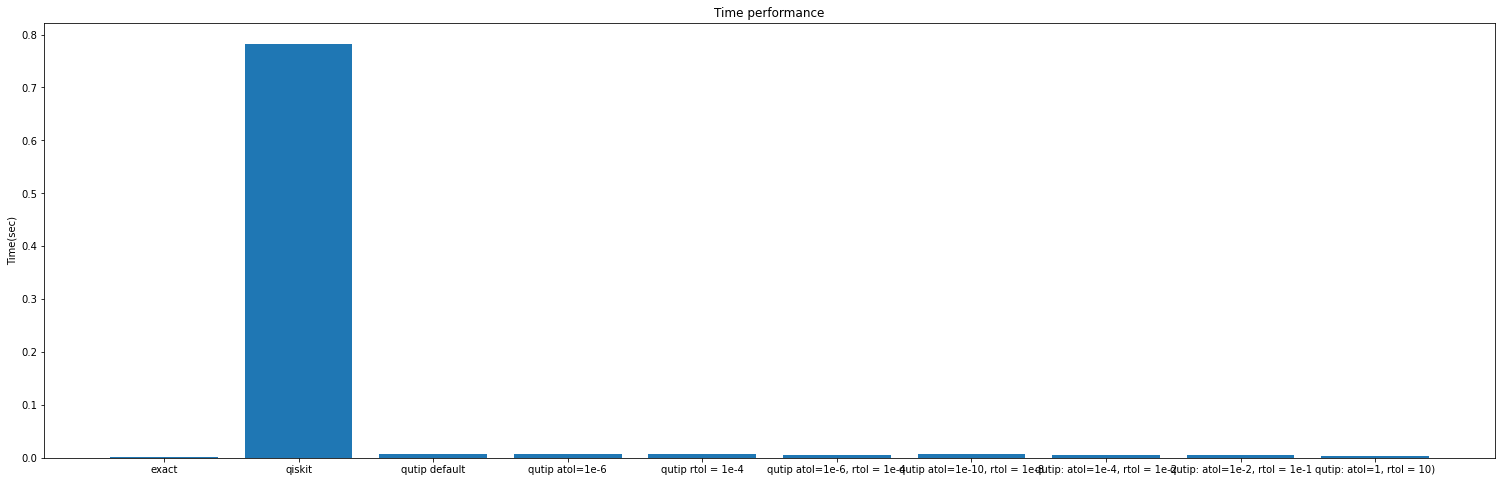

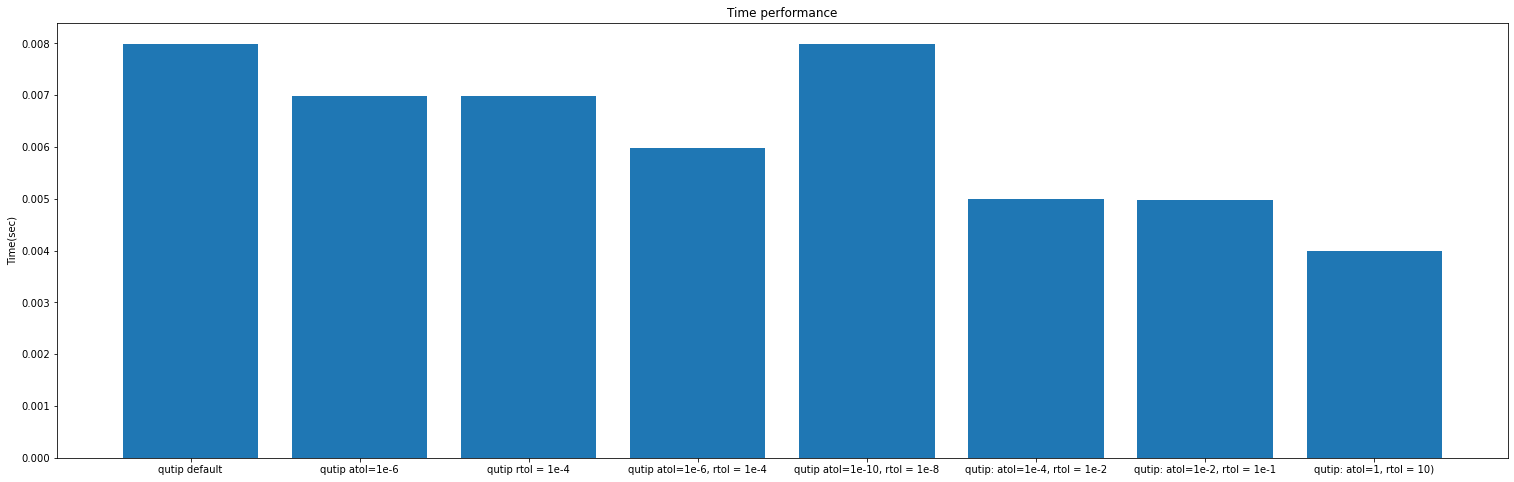

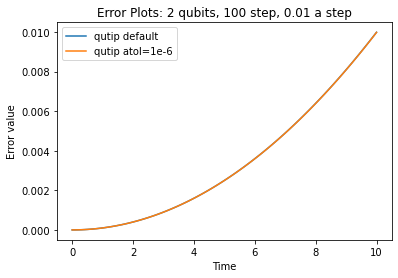

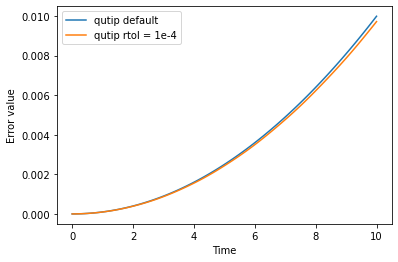

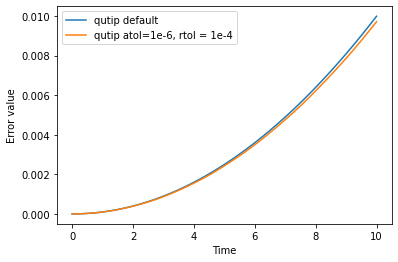

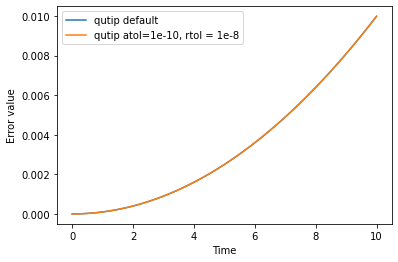

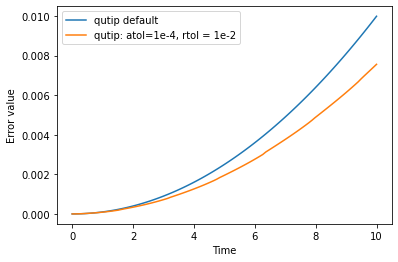

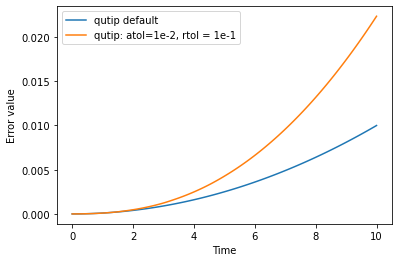

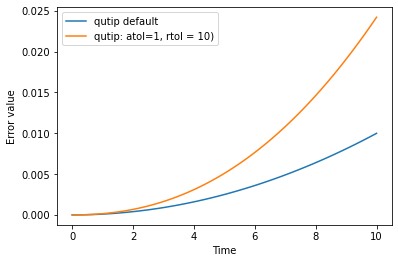

In [78]:
error_qiskit = []
# error_qiskit_1 = []

error_1 = []
error_2 = []
error_3 = []
error_4 = []
error_5 = []
error_6 = []
error_7 = []
error_8 = []
for i in range(100):
    vec_qiskit = []
#     vec_qiskit_1 = []
    vec_1 = []
    vec_2 = []
    vec_3 = []
    vec_4 = []
    vec_5 = []
    vec_6 = []
    vec_7 = []
    vec_8 = []
    for j in range(np.power(2, n)):
        vec_qiskit.append(qiskit_sim[i][j] - exact_sim[i][j])
#         vec_qiskit_1.append(qiskit_1[i][j] - exact_sim[i][j])
        vec_1.append(qutib_sim_1[i][j] - exact_sim[i][j])
        vec_2.append(qutib_sim_2[i][j] - exact_sim[i][j])
        vec_3.append(qutib_sim_3[i][j] - exact_sim[i][j])
        vec_4.append(qutib_sim_4[i][j] - exact_sim[i][j])
        vec_5.append(qutib_sim_5[i][j] - exact_sim[i][j])
        vec_6.append(qutib_sim_6[i][j] - exact_sim[i][j])
        vec_7.append(qutib_sim_7[i][j] - exact_sim[i][j])
        vec_8.append(qutib_sim_8[i][j] - exact_sim[i][j])
    error_qiskit.append(np.abs(np.vdot(vec_qiskit, vec_qiskit)))
#     error_qiskit_1.append(np.abs(np.vdot(vec_qiskit_1, vec_qiskit_1)))
    error_1.append(np.abs(np.vdot(vec_1, vec_1)))
    error_2.append(np.abs(np.vdot(vec_2, vec_2)))
    error_3.append(np.abs(np.vdot(vec_3, vec_3)))
    error_4.append(np.abs(np.vdot(vec_4, vec_4)))
    error_5.append(np.abs(np.vdot(vec_5, vec_5)))
    error_6.append(np.abs(np.vdot(vec_6, vec_6)))
    error_7.append(np.abs(np.vdot(vec_7, vec_7)))
    error_8.append(np.abs(np.vdot(vec_8, vec_8)))



# fig1 = plt.figure(1)
# p = plt.subplot()
# p.plot(times, error_qiskit)
# p.plot(times, error_qiskit_1)
# p.legend(("qiskit", "appx qiskit"))


p = plt.figure(12)
p.set_figwidth(26)
p.set_figheight(8)
p = plt.subplot()
p.bar(["exact", "qiskit", "qutip default", "qutip atol=1e-6", "qutip rtol = 1e-4", 
       "qutip atol=1e-6, rtol = 1e-4","qutip atol=1e-10, rtol = 1e-8", 
       "qutip: atol=1e-4, rtol = 1e-2","qutip: atol=1e-2, rtol = 1e-1",
      "qutip: atol=1, rtol = 10)" ], time_perf )
p.set_title("Time performance")
p.set_ylabel('Time(sec)')

p = plt.figure(13)
p.set_figwidth(26)
p.set_figheight(8)
p = plt.subplot()
p.bar(["qutip default", "qutip atol=1e-6", "qutip rtol = 1e-4", 
       "qutip atol=1e-6, rtol = 1e-4","qutip atol=1e-10, rtol = 1e-8", 
       "qutip: atol=1e-4, rtol = 1e-2","qutip: atol=1e-2, rtol = 1e-1",
      "qutip: atol=1, rtol = 10)" ], time_perf[2:10] )
p.set_title("Time performance")
p.set_ylabel('Time(sec)')


plt.figure(2)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_2)
p.set_title("Error Plots: 2 qubits, 100 step, 0.01 a step")
p.legend(("qutip default", "qutip atol=1e-6",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(3)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_3)
p.legend(("qutip default", "qutip rtol = 1e-4",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(4)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_4)
p.legend(("qutip default", "qutip atol=1e-6, rtol = 1e-4",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(5)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_5)
p.legend(("qutip default", "qutip atol=1e-10, rtol = 1e-8",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(6)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_6)
p.legend(("qutip default", "qutip: atol=1e-4, rtol = 1e-2",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(7)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_7)
p.legend(("qutip default", "qutip: atol=1e-2, rtol = 1e-1",))
p.set_xlabel('Time') 
p.set_ylabel('Error value')

plt.figure(8)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_8)
p.legend(("qutip default", "qutip: atol=1, rtol = 10)",))
p.set_xlabel('Time') 
p.set_ylabel('Error value')




 
 


It is expected that as the time step decrease, the error decreases:

In [79]:
# number of qubits
n = 2

# define time steps
times = np.linspace(0.0, 10, 1000)

time_perf = []

# exact------------------------------------------------
exact_sim, t = exact_simulate(n, 0.01, 1000)
time_perf.append(t)

# qiskit-----------------------------------------------
qiskit_sim, t = qiskit_simulate(n, 0.01, 1000)
time_perf.append(t)

# qiskit_1 = appx_qiskit_simulate(n, 0.1, 100)


# qutip------------------------------------------------
# default
qutib_sim_1, t = qutib_simulate(n, times, Options())
time_perf.append(t)

# increase the absolute tolerance (previously 1e-8)
options = Options(atol=1e-6)
qutib_sim_2, t = qutib_simulate(n, times, options)
time_perf.append(t)

# increase the relative tolerance (previously 1e-6)
options = Options(rtol = 1e-4)
qutib_sim_3, t = qutib_simulate(n, times, options)
time_perf.append(t)

# increase both the relative and absolute tolerance
options = Options(atol=1e-6, rtol = 1e-4)
qutib_sim_4, t = qutib_simulate(n, times, options)
time_perf.append(t)

# decrease the absolute and relative tolerance
options = Options(atol=1e-10, rtol = 1e-8)
qutib_sim_5, t = qutib_simulate(n, times, options)
time_perf.append(t)

# increase the abs and rlt more
options = Options(atol=1e-4, rtol = 1e-2)
qutib_sim_6, t = qutib_simulate(n, times, options)
time_perf.append(t)

options = Options(atol=1e-2, rtol = 1e-1)
qutib_sim_7, t = qutib_simulate(n, times, options)
time_perf.append(t)

# options = Options(atol=1, rtol = 10, method="bdf", order = 5)
# qutib_sim_7 = qutib_simulate(n, times, options)

options = Options(atol=1, rtol = 10)
qutib_sim_8, t = qutib_simulate(n, times, options)
time_perf.append(t)

print("done")

done


Text(0, 0.5, 'Error value')

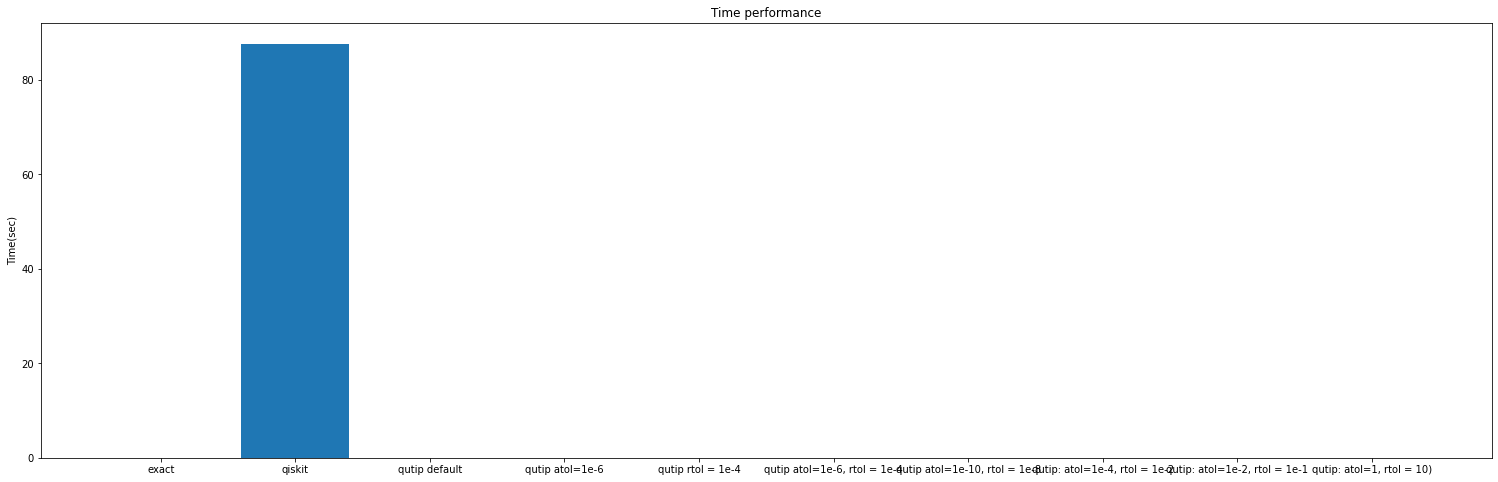

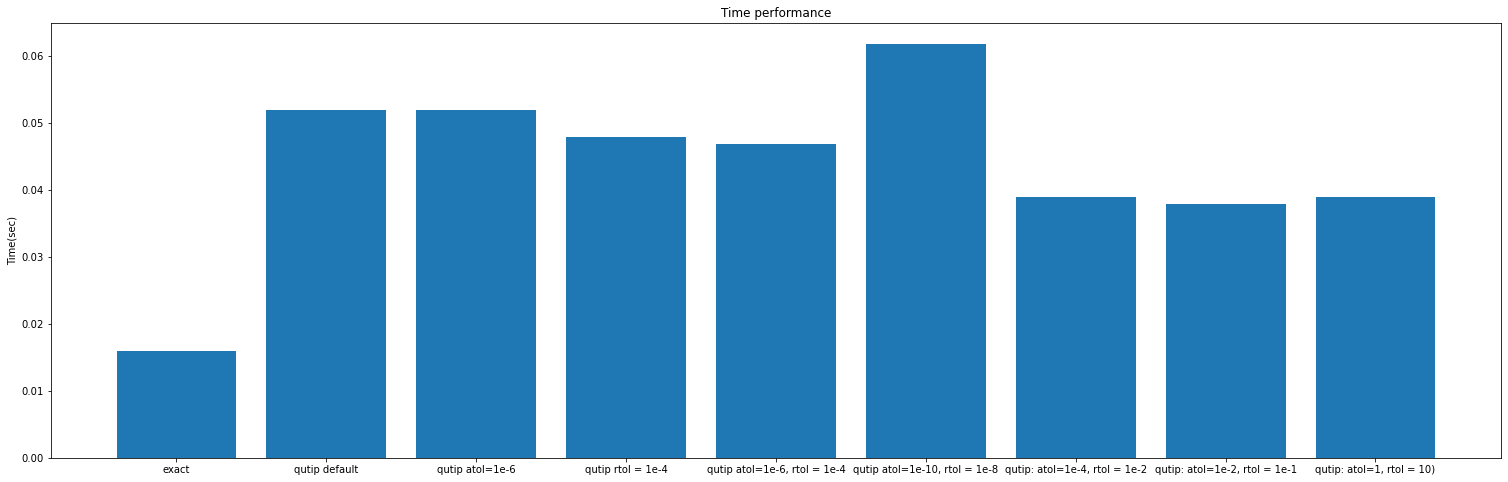

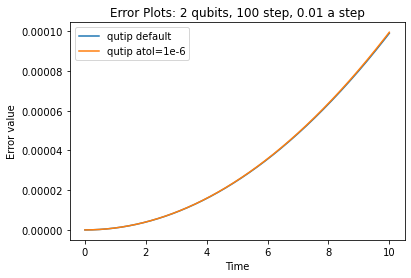

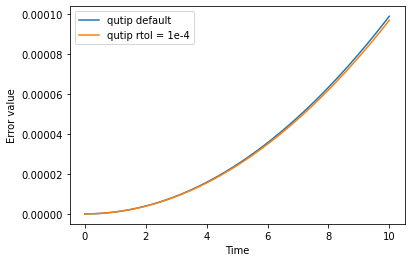

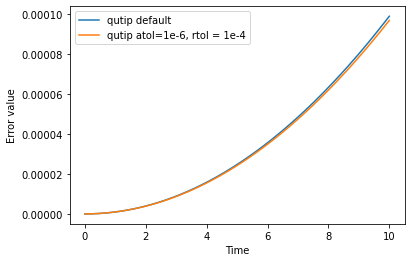

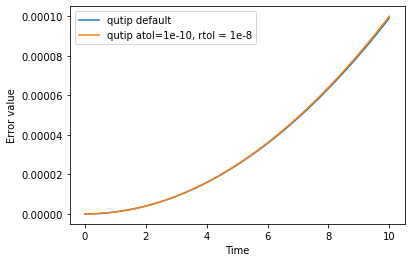

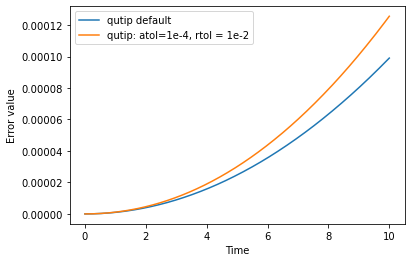

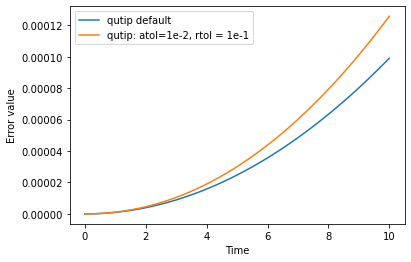

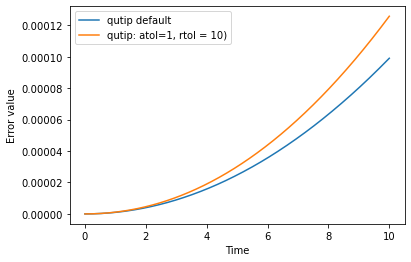

In [85]:
error_qiskit = []
# error_qiskit_1 = []

error_1 = []
error_2 = []
error_3 = []
error_4 = []
error_5 = []
error_6 = []
error_7 = []
error_8 = []
for i in range(1000):
    vec_qiskit = []
#     vec_qiskit_1 = []
    vec_1 = []
    vec_2 = []
    vec_3 = []
    vec_4 = []
    vec_5 = []
    vec_6 = []
    vec_7 = []
    vec_8 = []
    for j in range(np.power(2, n)):
        vec_qiskit.append(qiskit_sim[i][j] - exact_sim[i][j])
#         vec_qiskit_1.append(qiskit_1[i][j] - exact_sim[i][j])
        vec_1.append(qutib_sim_1[i][j] - exact_sim[i][j])
        vec_2.append(qutib_sim_2[i][j] - exact_sim[i][j])
        vec_3.append(qutib_sim_3[i][j] - exact_sim[i][j])
        vec_4.append(qutib_sim_4[i][j] - exact_sim[i][j])
        vec_5.append(qutib_sim_5[i][j] - exact_sim[i][j])
        vec_6.append(qutib_sim_6[i][j] - exact_sim[i][j])
        vec_7.append(qutib_sim_7[i][j] - exact_sim[i][j])
        vec_8.append(qutib_sim_8[i][j] - exact_sim[i][j])
    error_qiskit.append(np.abs(np.vdot(vec_qiskit, vec_qiskit)))
#     error_qiskit_1.append(np.abs(np.vdot(vec_qiskit_1, vec_qiskit_1)))
    error_1.append(np.abs(np.vdot(vec_1, vec_1)))
    error_2.append(np.abs(np.vdot(vec_2, vec_2)))
    error_3.append(np.abs(np.vdot(vec_3, vec_3)))
    error_4.append(np.abs(np.vdot(vec_4, vec_4)))
    error_5.append(np.abs(np.vdot(vec_5, vec_5)))
    error_6.append(np.abs(np.vdot(vec_6, vec_6)))
    error_7.append(np.abs(np.vdot(vec_7, vec_7)))
    error_8.append(np.abs(np.vdot(vec_8, vec_8)))



# fig1 = plt.figure(1)
# p = plt.subplot()
# p.plot(times, error_qiskit)
# p.plot(times, error_qiskit_1)
# p.legend(("qiskit", "appx qiskit"))


p = plt.figure(12)
p.set_figwidth(26)
p.set_figheight(8)
p = plt.subplot()
p.bar(["exact", "qiskit", "qutip default", "qutip atol=1e-6", "qutip rtol = 1e-4", 
       "qutip atol=1e-6, rtol = 1e-4","qutip atol=1e-10, rtol = 1e-8", 
       "qutip: atol=1e-4, rtol = 1e-2","qutip: atol=1e-2, rtol = 1e-1",
      "qutip: atol=1, rtol = 10)" ], time_perf )
p.set_title("Time performance")
p.set_ylabel('Time(sec)')

p = plt.figure(13)
p.set_figwidth(26)
p.set_figheight(8)
p = plt.subplot()
del time_perf[1]
p.bar(["exact", "qutip default", "qutip atol=1e-6", "qutip rtol = 1e-4", 
       "qutip atol=1e-6, rtol = 1e-4","qutip atol=1e-10, rtol = 1e-8", 
       "qutip: atol=1e-4, rtol = 1e-2","qutip: atol=1e-2, rtol = 1e-1",
      "qutip: atol=1, rtol = 10)" ], time_perf )
p.set_title("Time performance")
p.set_ylabel('Time(sec)')


plt.figure(2)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_2)
p.set_title("Error Plots: 2 qubits, 100 step, 0.01 a step")
p.legend(("qutip default", "qutip atol=1e-6",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(3)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_3)
p.legend(("qutip default", "qutip rtol = 1e-4",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(4)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_4)
p.legend(("qutip default", "qutip atol=1e-6, rtol = 1e-4",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(5)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_5)
p.legend(("qutip default", "qutip atol=1e-10, rtol = 1e-8",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(6)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_6)
p.legend(("qutip default", "qutip: atol=1e-4, rtol = 1e-2",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(7)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_7)
p.legend(("qutip default", "qutip: atol=1e-2, rtol = 1e-1",))
p.set_xlabel('Time') 
p.set_ylabel('Error value')

plt.figure(8)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_8)
p.legend(("qutip default", "qutip: atol=1, rtol = 10)",))
p.set_xlabel('Time') 
p.set_ylabel('Error value')

## Three qubits case
Here for the exact result, I will use qiskit circuit model. 

In [75]:
# number of qubits
n = 3

# define time steps
times = np.linspace(0.0, 10, 100)

time_perf = []

# exact------------------------------------------------
exact_sim, t = qiskit_simulate(n, 0.1, 100)
time_perf.append(t)

# qiskit-----------------------------------------------
qiskit_sim, t = qiskit_simulate(n, 0.1, 100)
time_perf.append(t)

# qiskit_1 = appx_qiskit_simulate(n, 0.1, 100)


# qutip------------------------------------------------
# default
qutib_sim_1, t = qutib_simulate(n, times, Options())
time_perf.append(t)

# increase the absolute tolerance (previously 1e-8)
options = Options(atol=1e-6)
qutib_sim_2, t = qutib_simulate(n, times, options)
time_perf.append(t)

# increase the relative tolerance (previously 1e-6)
options = Options(rtol = 1e-4)
qutib_sim_3, t = qutib_simulate(n, times, options)
time_perf.append(t)

# increase both the relative and absolute tolerance
options = Options(atol=1e-6, rtol = 1e-4)
qutib_sim_4, t = qutib_simulate(n, times, options)
time_perf.append(t)

# decrease the absolute and relative tolerance
options = Options(atol=1e-10, rtol = 1e-8)
qutib_sim_5, t = qutib_simulate(n, times, options)
time_perf.append(t)

# increase the abs and rlt more
options = Options(atol=1e-4, rtol = 1e-2)
qutib_sim_6, t = qutib_simulate(n, times, options)
time_perf.append(t)

options = Options(atol=1e-2, rtol = 1e-1)
qutib_sim_7, t = qutib_simulate(n, times, options)
time_perf.append(t)

# options = Options(atol=1, rtol = 10, method="bdf", order = 5)
# qutib_sim_7 = qutib_simulate(n, times, options)

options = Options(atol=1, rtol = 10)
qutib_sim_8, t = qutib_simulate(n, times, options)
time_perf.append(t)

print("done")


done


Text(0, 0.5, 'Error value')

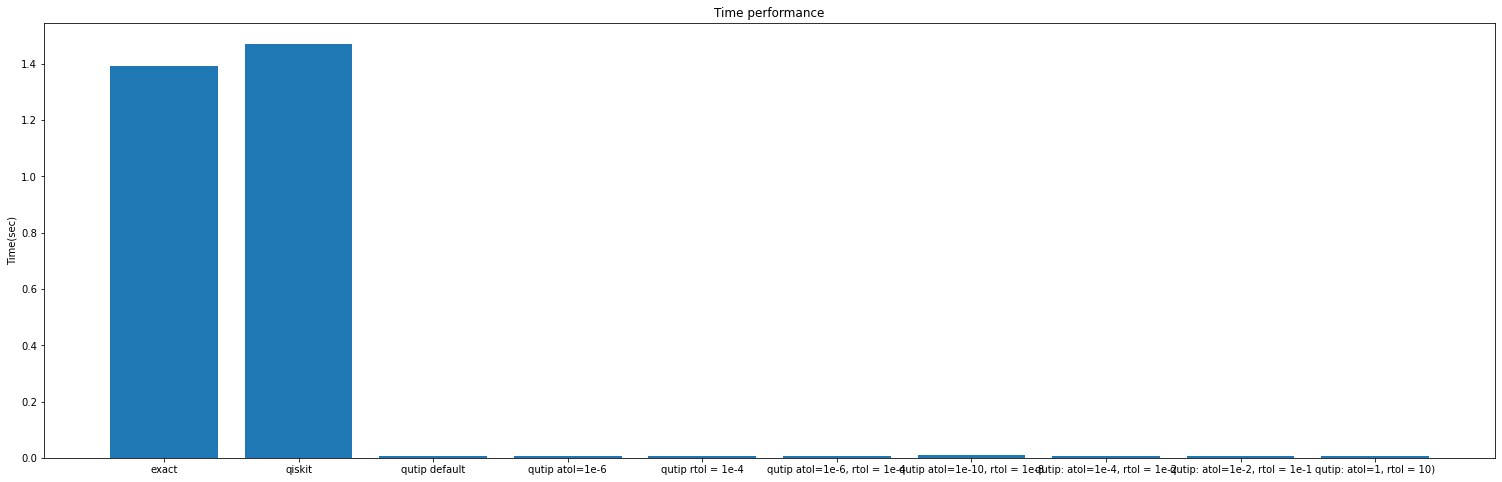

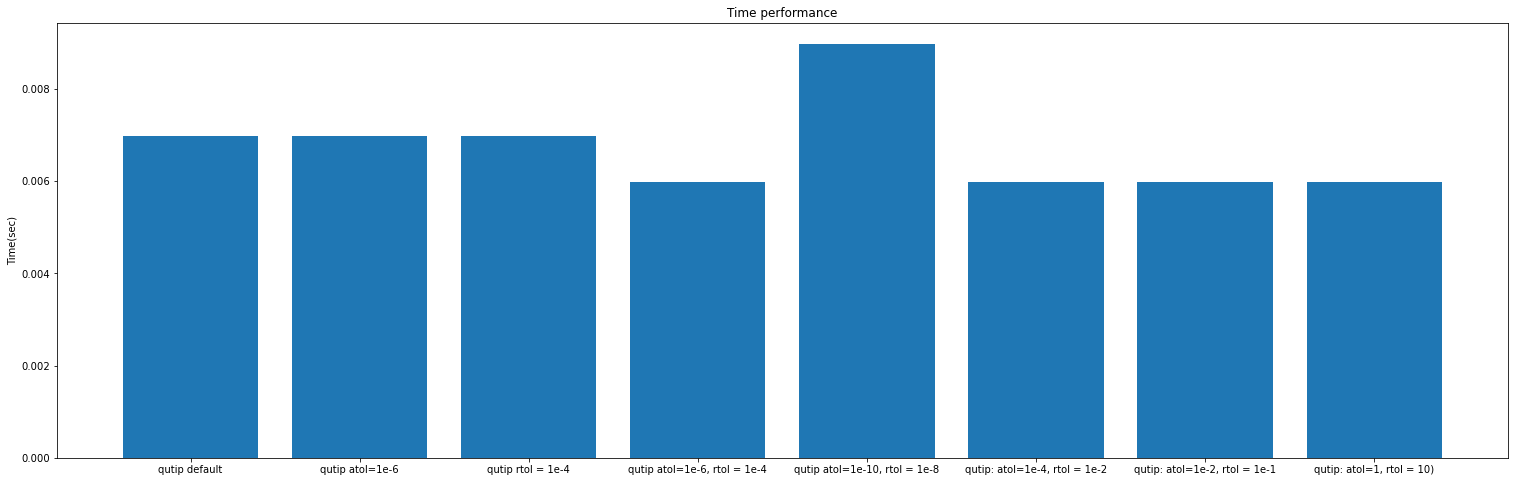

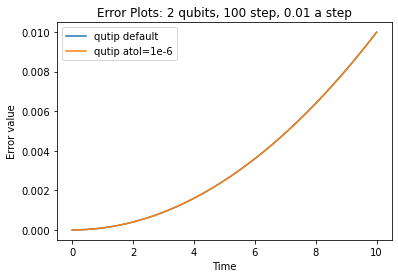

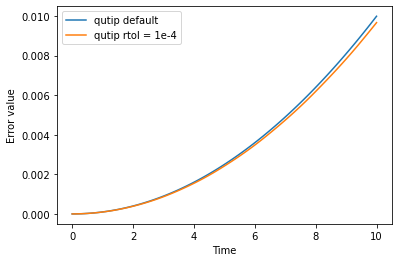

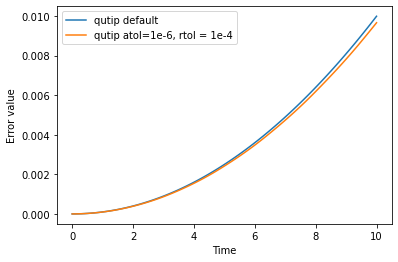

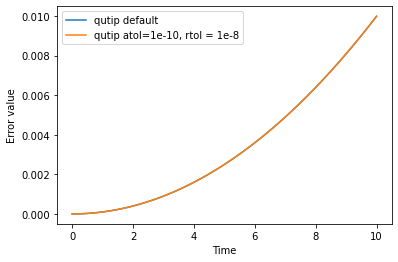

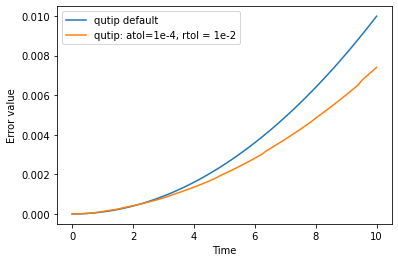

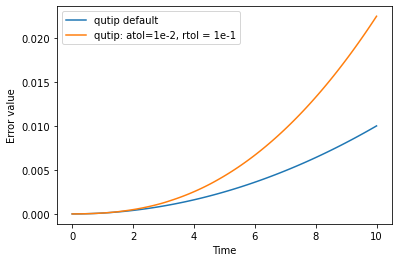

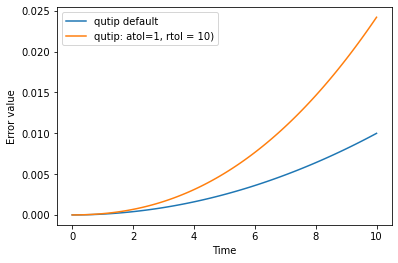

In [76]:
error_qiskit = []
# error_qiskit_1 = []

error_1 = []
error_2 = []
error_3 = []
error_4 = []
error_5 = []
error_6 = []
error_7 = []
error_8 = []
for i in range(100):
    vec_qiskit = []
#     vec_qiskit_1 = []
    vec_1 = []
    vec_2 = []
    vec_3 = []
    vec_4 = []
    vec_5 = []
    vec_6 = []
    vec_7 = []
    vec_8 = []
    for j in range(np.power(2, n)):
        vec_qiskit.append(qiskit_sim[i][j] - exact_sim[i][j])
#         vec_qiskit_1.append(qiskit_1[i][j] - exact_sim[i][j])
        vec_1.append(qutib_sim_1[i][j] - exact_sim[i][j])
        vec_2.append(qutib_sim_2[i][j] - exact_sim[i][j])
        vec_3.append(qutib_sim_3[i][j] - exact_sim[i][j])
        vec_4.append(qutib_sim_4[i][j] - exact_sim[i][j])
        vec_5.append(qutib_sim_5[i][j] - exact_sim[i][j])
        vec_6.append(qutib_sim_6[i][j] - exact_sim[i][j])
        vec_7.append(qutib_sim_7[i][j] - exact_sim[i][j])
        vec_8.append(qutib_sim_8[i][j] - exact_sim[i][j])
    error_qiskit.append(np.abs(np.vdot(vec_qiskit, vec_qiskit)))
#     error_qiskit_1.append(np.abs(np.vdot(vec_qiskit_1, vec_qiskit_1)))
    error_1.append(np.abs(np.vdot(vec_1, vec_1)))
    error_2.append(np.abs(np.vdot(vec_2, vec_2)))
    error_3.append(np.abs(np.vdot(vec_3, vec_3)))
    error_4.append(np.abs(np.vdot(vec_4, vec_4)))
    error_5.append(np.abs(np.vdot(vec_5, vec_5)))
    error_6.append(np.abs(np.vdot(vec_6, vec_6)))
    error_7.append(np.abs(np.vdot(vec_7, vec_7)))
    error_8.append(np.abs(np.vdot(vec_8, vec_8)))



# fig1 = plt.figure(1)
# p = plt.subplot()
# p.plot(times, error_qiskit)
# p.plot(times, error_qiskit_1)
# p.legend(("qiskit", "appx qiskit"))


p = plt.figure(12)
p.set_figwidth(26)
p.set_figheight(8)
p = plt.subplot()
p.bar(["exact", "qiskit", "qutip default", "qutip atol=1e-6", "qutip rtol = 1e-4", 
       "qutip atol=1e-6, rtol = 1e-4","qutip atol=1e-10, rtol = 1e-8", 
       "qutip: atol=1e-4, rtol = 1e-2","qutip: atol=1e-2, rtol = 1e-1",
      "qutip: atol=1, rtol = 10)" ], time_perf )
p.set_title("Time performance")
p.set_ylabel('Time(sec)')

p = plt.figure(13)
p.set_figwidth(26)
p.set_figheight(8)
p = plt.subplot()
p.bar(["qutip default", "qutip atol=1e-6", "qutip rtol = 1e-4", 
       "qutip atol=1e-6, rtol = 1e-4","qutip atol=1e-10, rtol = 1e-8", 
       "qutip: atol=1e-4, rtol = 1e-2","qutip: atol=1e-2, rtol = 1e-1",
      "qutip: atol=1, rtol = 10)" ], time_perf[2:10] )
p.set_title("Time performance")
p.set_ylabel('Time(sec)')


plt.figure(2)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_2)
p.set_title("Error Plots: 2 qubits, 100 step, 0.01 a step")
p.legend(("qutip default", "qutip atol=1e-6",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(3)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_3)
p.legend(("qutip default", "qutip rtol = 1e-4",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(4)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_4)
p.legend(("qutip default", "qutip atol=1e-6, rtol = 1e-4",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(5)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_5)
p.legend(("qutip default", "qutip atol=1e-10, rtol = 1e-8",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(6)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_6)
p.legend(("qutip default", "qutip: atol=1e-4, rtol = 1e-2",))
p.set_xlabel('Time') 
p.set_ylabel('Error value') 

plt.figure(7)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_7)
p.legend(("qutip default", "qutip: atol=1e-2, rtol = 1e-1",))
p.set_xlabel('Time') 
p.set_ylabel('Error value')

plt.figure(8)
p = plt.subplot()
p.plot(times, error_1) 
p.plot(times, error_8)
p.legend(("qutip default", "qutip: atol=1, rtol = 10)",))
p.set_xlabel('Time') 
p.set_ylabel('Error value')




 
 


In [84]:

r = time_perf
print(r)

[0.01594400405883789, 87.71291518211365, 0.05186295509338379, 0.05185890197753906, 0.04787254333496094, 0.04687976837158203, 0.061829566955566406, 0.03889036178588867, 0.03789806365966797, 0.038895606994628906]
